In [1]:
import csv
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/cleaned.csv')

In [3]:
models_df = pd.DataFrame(columns=['score_train','score_test','r2','MSE','RMSE'],
                         index=['Model_1_test','Model_2_test','Model_3_test','Model_4_test','Model_5_test'])

In [4]:
def all_the_metrics(model_name,score_1,y_t,y_p,score_2,y_t_test,y_p_test):
    models_df.loc[model_name+"_test",'score_train'] = score_1
    models_df.loc[model_name+"_test",'score_test'] = score_2
    models_df.loc[model_name+"_test",'r2'] = metrics.r2_score(y_t_test,y_p_test)
    models_df.loc[model_name+"_test",'MSE'] = metrics.mean_squared_error(y_t_test,y_p_test)
    models_df.loc[model_name+"_test",'RMSE'] = np.sqrt(metrics.mean_squared_error(y_t_test,y_p_test))

### All Categorical Models

I'll start by dummy-ing them, which will give me a total of 394 columns. Then I'll focus on 4 key steps in my pipe, using `GridSearchCV` to optimize for the best parameters:
1. StandardScale the data
2. SelectKBest features
3. Run LinearRegression

*Note*: To ensure readability of these models, I have turned `verbose` to `0` when running `GridSearchCV` for the final submission. However, in my testing, I kept it on, and made sure to look at `model.best_estimator_` so that I could effectively refine the model towards its peak performance. So each step, with fine tuned adjustments, is a result of building off of `model.best_estimator_` to best tune the hyperparameters.

In [5]:
df = pd.get_dummies(df, columns=list(df.select_dtypes(exclude=['int64','float64']).columns))
all_cols = df.drop(['SalePrice','SalePrice_deskewed','Unnamed: 0', 'Id', 'PID'], 1).columns

In [6]:
lr = LinearRegression()

X = df[all_cols]
y = df['SalePrice_deskewed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with open('../assets/columns.pkl', 'wb+') as f:
    pickle.dump(list(X.columns), f)

In [7]:
steps = [
    ("scaler", StandardScaler()),
    ("kbest", SelectKBest(score_func=f_regression)),
    ("lr", LinearRegression())
]

pipe = Pipeline(steps)

In [8]:
def run_model(param_grid,name):
    gs = GridSearchCV(pipe,param_grid,verbose=0,cv=3,return_train_score=True,n_jobs=3)
    model = gs.fit(X_train,y_train)
    all_the_metrics(name,model.score(X_train,y_train),y_train,model.predict(X_train),
                    model.score(X_test,y_test),y_test,model.predict(X_test))
    
    with open('../assets/'+name+'_pipe.pkl', 'wb+') as f:
        pickle.dump(model, f)
    
    #print(model.best_estimator_, model.best_score_)

In [9]:
param_grid = {
    "kbest__k": [150,300,350,390]
}

run_model(param_grid,"Model_1")

**So there's a big problem. This model has a terrible score of `-1.0180763168509616e+21`. I'll stop trying to attempt KBest into LinearRegression, and go to ElasticNetCV.**

In [10]:
steps = [
    ("scaler", StandardScaler()),
    ("encv", ElasticNetCV(random_state=42))
]

pipe = Pipeline(steps)

In [11]:
param_grid = {
    "encv__cv": [9,11,13],
    "encv__l1_ratio": [.55,.65,.8]
}

run_model(param_grid,"Model_2")

I'm going to recreate that model, but:
1. Compare True vs. Predicted Values
2. Look at features with the strongest weight

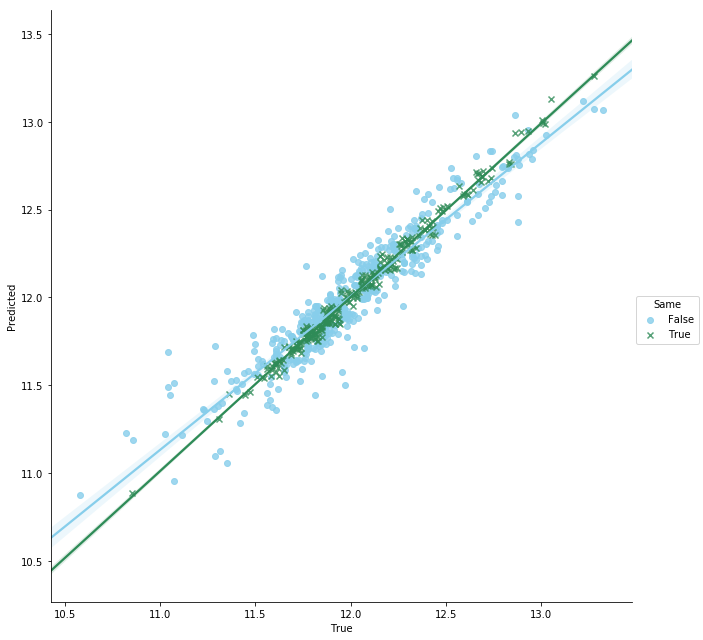

In [12]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train,y_train)
X_test_ss = ss.transform(X_test)

encv = ElasticNetCV(cv=11,l1_ratio=.65)
encv.fit(X_train_ss,y_train)

encv_coefs = pd.DataFrame({'Var':all_cols,
                           "Coef":encv.coef_})

encv_predict_df = pd.DataFrame({'True':y_test,
                           'Predicted':encv.predict(X_test_ss),
                           'Same':(np.round(y_test,1) == np.round(encv.predict(X_test_ss),1))})

sns.lmplot(x='True',y='Predicted',data=encv_predict_df,size=9, aspect=1,hue='Same',
           markers=["o", "x"],palette={True:"seagreen", False:"skyblue"});

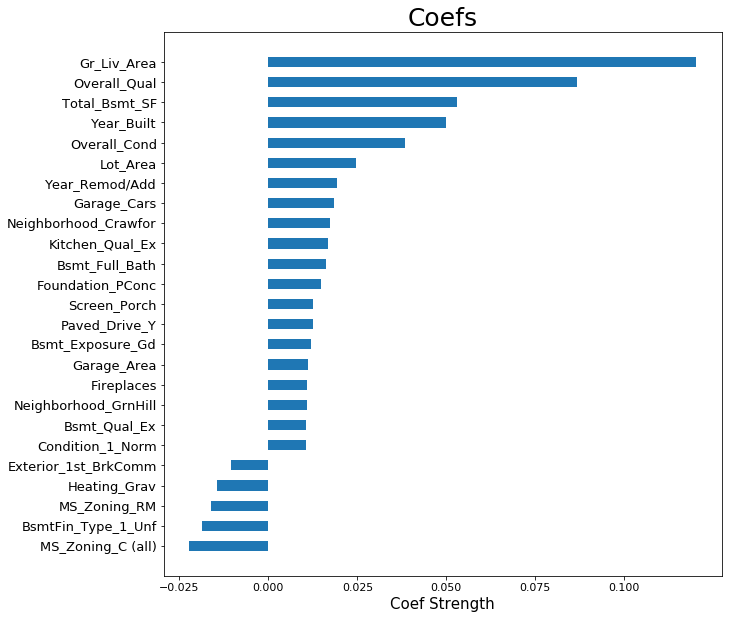

In [13]:
a = encv_coefs[(encv_coefs['Coef'] > .01) | (encv_coefs['Coef'] < -.01)].sort_values('Coef')['Coef']
b = encv_coefs[(encv_coefs['Coef'] > .01) | (encv_coefs['Coef'] < -.01)].sort_values('Coef')['Var']

N = len(a)
ind = np.arange(N)
width= .5

plt.barh(ind, a, width)

plt.xlabel('Coef Strength',fontsize=15)
plt.title('Coefs',fontsize=25)
plt.yticks(ind, b,fontsize=13)

plt.xticks(np.arange(-.025, .12, .025),fontsize=11)

a = plt.gcf()
a.set_size_inches(10, 10)

plt.show()

**For ElasticNetCV, these are the best values. Having a cv of 11, and an l1_ratio of .65.**

Also, it's very interesting to see that neighborhoods made it in as some of the strongest features.

**I'm going to look into other regression models to see if there are any other better options remaining. I'll try `KNeighborRegressor`.** This will allow the model to find prices based on other houses that have the most features in common. There are a few options such as how many neighbors; this will allow each point to take advantage of how many priced values are close by. There are also measures of metrics, which are different types of ways to measure the distances between the different variables. There are also weights, such as uniform and distance. Uniform will treat all near neighbors equally, while distance will give more weight to those neighbors that are closer.

In [14]:
steps = [
    ("scaler", StandardScaler()),
    ("knr", KNeighborsRegressor())
]

pipe = Pipeline(steps)

In [15]:
param_grid = {
    "knr__n_neighbors":[5,15,35],
    "knr__metric": ['euclidean','minkowski'],
    "knr__weights": ['uniform','distance']
}

run_model(param_grid,"Model_3")

**I'm going to add in `SelectKBest` so that there are less weaker variables in play.**

There are a **lot** of features currently in play, and I need to reduce the noise when KNR starts to model

In [16]:
steps = [
    ("scaler", StandardScaler()),
    ("kbest", SelectKBest()),
    ("knr", KNeighborsRegressor(metric='euclidean',weights='distance',algorithm='auto'))
]

pipe = Pipeline(steps)

In [17]:
param_grid = {
    "kbest__k": [140,145,150],
    "knr__n_neighbors":[9,13]
}

run_model(param_grid,"Model_4")

**It's different to see KNearstNeighbors for me. I'm going to look at the true vs. predicted values.**

In [18]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train,y_train)
X_test_ss = ss.transform(X_test)

kbest = SelectKBest(k=145)
X_train_kb = kbest.fit_transform(X_train_ss,y_train)
X_test_kb = kbest.transform(X_test_ss)

knr = KNeighborsRegressor(metric='euclidean',weights='distance',algorithm='auto',n_neighbors=9)
knr.fit(X_train_kb,y_train)

knr_predict_df = pd.DataFrame({'True':y_test,
                           'Predicted':knr.predict(X_test_kb),
                           'Same':(np.round(y_test,1) == np.round(knr.predict(X_test_kb),1))})

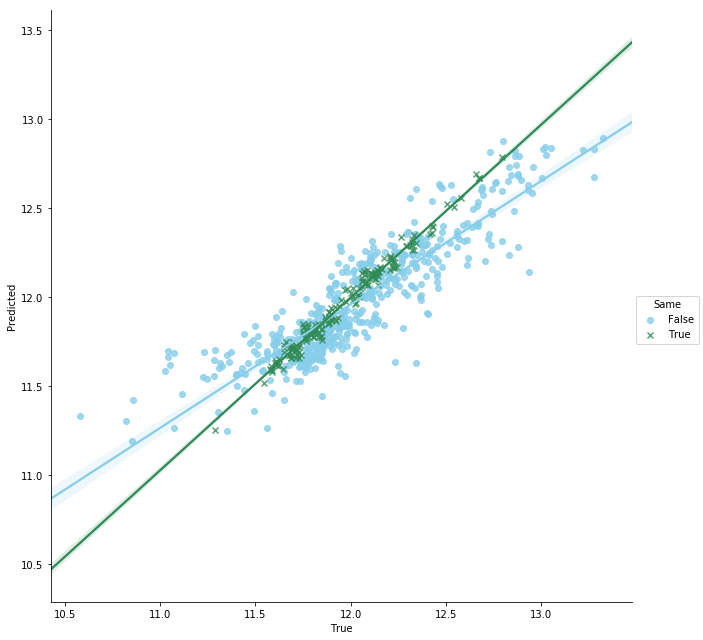

In [19]:
sns.lmplot(x='True',y='Predicted',data=knr_predict_df,size=9, aspect=1,hue='Same',
           markers=["o", "x"],palette={True:"seagreen", False:"skyblue"});

In reality, this didn't do so well. It's good that it's not overfit, but at the end of the day, it has a (deskewed) RMSE of nearly .15 which isn't that great.

**Now, instead of SelectKBest, I'm going to try `VarianceThreshold` so that there are less weaker variables in play.**

In [20]:
steps = [
    ("var_thresh", VarianceThreshold()),
    ("scaler", StandardScaler()),
    ("knr", KNeighborsRegressor(metric='euclidean',weights='distance',algorithm='auto',n_neighbors=9))
]

pipe = Pipeline(steps)

In [21]:
param_grid = {
    "var_thresh__threshold": [.24,.23,.22], # I chose these after a few attempts
}

run_model(param_grid,"Model_5")

**Again, I want to look at this model and compare true vs predicted.**

In [22]:
var_thresh = VarianceThreshold(threshold=.23)
X_train_vt = var_thresh.fit_transform(X_train,y_train)
X_test_vt = var_thresh.transform(X_test)

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_vt,y_train)
X_test_ss = ss.transform(X_test_vt)

knr = KNeighborsRegressor(metric='euclidean',weights='distance',algorithm='auto',n_neighbors=9)
knr.fit(X_train_ss,y_train)

knr_predict_df = pd.DataFrame({'True':y_test,
                           'Predicted':knr.predict(X_test_ss),
                           'Same':(np.round(y_test,1) == np.round(knr.predict(X_test_ss),1))})

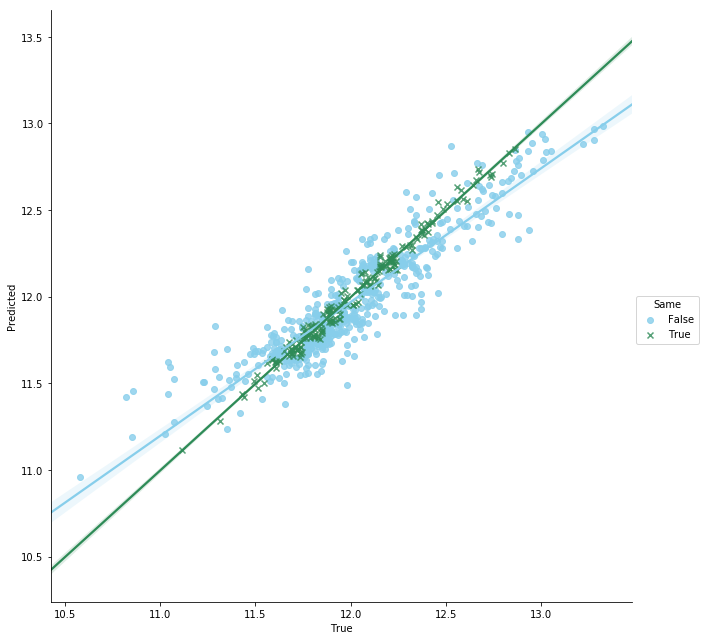

In [23]:
sns.lmplot(x='True',y='Predicted',data=knr_predict_df,size=9, aspect=1,hue='Same',
           markers=["o", "x"],palette={True:"seagreen", False:"skyblue"});

### Let's look at the overall results.

In [24]:
models_df

,score_train,score_test,r2,MSE,RMSE
Model_1_test,0.936854,-9.04811e+16,-9.04811e+16,1.3728e+16,1.17166e+08
Model_2_test,0.943925,0.917873,0.917873,0.0124605,0.111626
Model_3_test,1,0.716321,0.716321,0.0430404,0.207462
Model_4_test,0.999994,0.785089,0.785089,0.0326067,0.180573
Model_5_test,1,0.852086,0.852086,0.0224418,0.149806


Neither of these last two models seem to fair that well. That's because there's no coefficient suppressor like in `ElasticNetCV`. Moving forward, I will focus on my best ElasticNetCV model, and will focus on weights of upgradeable features.